## Importando as bibliotecas

In [1]:
import msgpack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict

from geexhp.conversores import converter_configuracao
from geexhp.modificadores import mod_telescopio, mod_valor_gas, modificador_aleatorio
from geexhp.analisadores import EspectroAnalise
from geexhp.datagen import datagen
from geexhp.pypsg import PSG

## Primeiro Teste - Carregando arquivo de configuração do HWO para Terra moderna

In [2]:
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))
    
config_df = converter_configuracao(config)

In [3]:
#api_user: str = "https://10.2.180.164/api.php"
psg = PSG(timeout_seconds = 200)

Testing connection to PSG at https://psg.gsfc.nasa.gov/api.php ...
Connected to PSG with success.


In [10]:
config_HWC = config.copy()
mod_telescopio(config_HWC, instrumento='HWC')     # HabEx Workforce Camera (HWC)
resultado = psg.run(config_HWC)

In [12]:
spectrum = EspectroAnalise(resultado)
spectrum.converter_para_dataframe()

,Wave/freq [um],Total [I/F apparent albedo],Noise,Planet
0,0.370000,0.102022,0.129523,0.102022
1,0.370370,0.101932,0.130016,0.101932
2,0.370740,0.101843,0.130330,0.101843
3,0.371111,0.101752,0.130759,0.101752
4,0.371482,0.101661,0.132349,0.101661
...,...,...,...,...
1578,1.791332,0.005067,0.485152,0.005067
1579,1.793123,0.001620,0.487056,0.001620
1580,1.794916,0.003894,0.489079,0.003894
1581,1.796711,0.003114,0.491635,0.003114


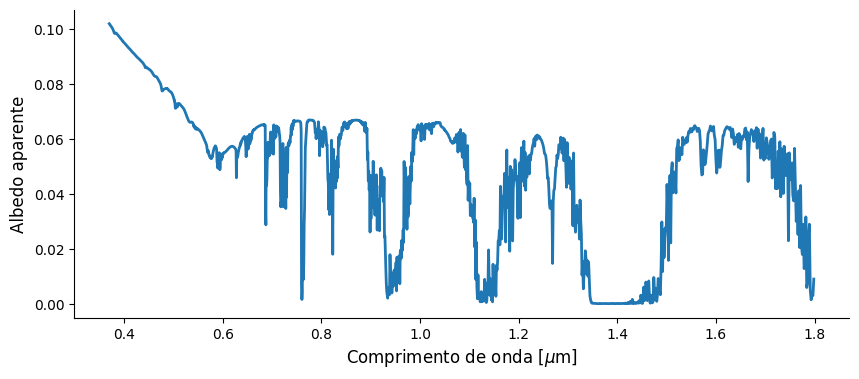

In [13]:
spectrum.plotar_espectro();

In [49]:
## Colocando o HabEx StarShade (SS)

# UV (0.2 to 0.45 um) 
config_SSUV = config.copy()
mod_telescopio(config_SSUV, instrumento='SS-UV')    
resultado = psg.run(config_SSUV)
spectrum_SSUV = EspectroAnalise(resultado)
df_SSUV = spectrum_SSUV.converter_para_dataframe()

# visible (0.45 to 1um)
config_SSVis = config.copy()
resultado = psg.run(config_SSVis)
spectrum_SSVis = EspectroAnalise(resultado)
df_SSVis = spectrum_SSVis.converter_para_dataframe()

# infrared (0.975 to 1.8 um)
config_SSNIR = config.copy()
mod_telescopio(config_SSNIR, instrumento='SS-NIR')  
resultado = psg.run(config_SSNIR)
spectrum_SSNIR = EspectroAnalise(resultado)
df_SSNIR = spectrum_SSNIR.converter_para_dataframe()

df = pd.concat([df_SSUV, df_SSVis, df_SSNIR])
df.reset_index(drop=True, inplace=True)

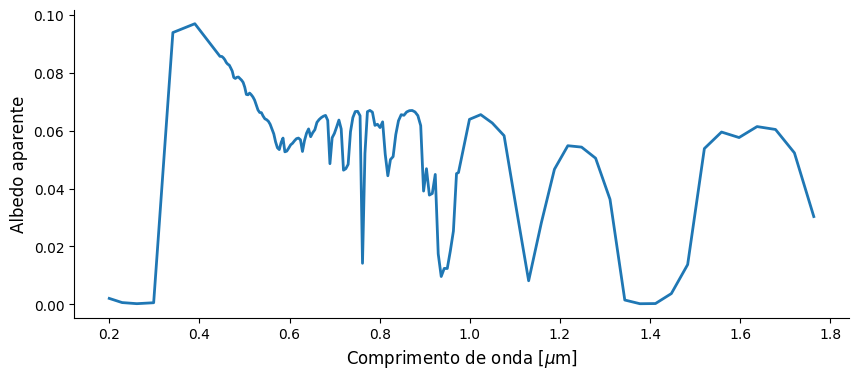

In [62]:
wave_freq = df["Wave/freq [um]"]
total_albedo = df["Total [I/F apparent albedo]"]
erro = df["Noise"]

_, ax = plt.subplots()
ax.plot(wave_freq, total_albedo, color="tab:blue", lw=2)
#ax.errorbar(wave_freq, total_albedo, yerr=erro, fmt="o", capsize=3, color="gray", alpha=0.35, markersize=5)

ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente");

## Teste 2 - Mudando as abundâncias

In [64]:
# Dobrando o valor de O2
config_dobro_O2 = config.copy()
mod_telescopio(config_dobro_O2, instrumento="HWC") 
mod_valor_gas(config_dobro_O2, "O2", 2)
resultado_dobro_O2 = psg.run(config_dobro_O2)

In [65]:
# Tirando O2 da atmosfera
config_sem_O2 = config.copy()
mod_telescopio(config_sem_O2,  instrumento="HWC") 
mod_valor_gas(config_sem_O2, "O2", 0)
resultado_sem_O2 = psg.run(config_sem_O2)

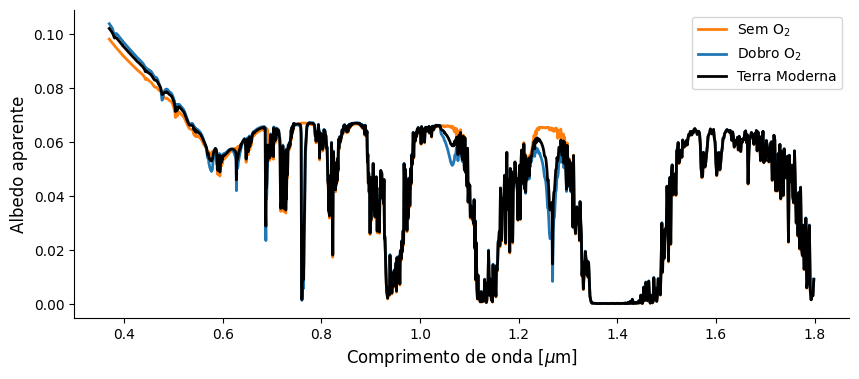

In [66]:
spectrum_dobro_02 = EspectroAnalise(resultado_dobro_O2)
spectrum_sem_02 = EspectroAnalise(resultado_sem_O2)

_, ax = plt.subplots()
spectrum_sem_02.plotar_espectro(ax=ax, label="Sem O${}_2$", cor_linha="tab:orange")
spectrum_dobro_02.plotar_espectro(ax=ax, label="Dobro O${}_2$", cor_linha="tab:blue")
spectrum.plotar_espectro(ax=ax, label="Terra Moderna", cor_linha="k")
ax.legend();

## Teste 3 - Modificando a pressão atmosférica (mbar)

In [16]:
# 500 mbar = .5 bar
# O espectro não retornou nada para o dobro e 4x a pressão atmosférica
config_metade_atm = config.copy()
config_metade_atm["ATMOSPHERE-PRESSURE"] = 500
mod_telescopio(config_metade_atm, instrumento='HWC') 
resultado_metade_atm = psg.run(config_metade_atm)

config_15_atm = config.copy()
config_15_atm["ATMOSPHERE-PRESSURE"] = 1500
mod_telescopio(config_15_atm, instrumento='HWC') 
resultado_15_atm = psg.run(config_15_atm)

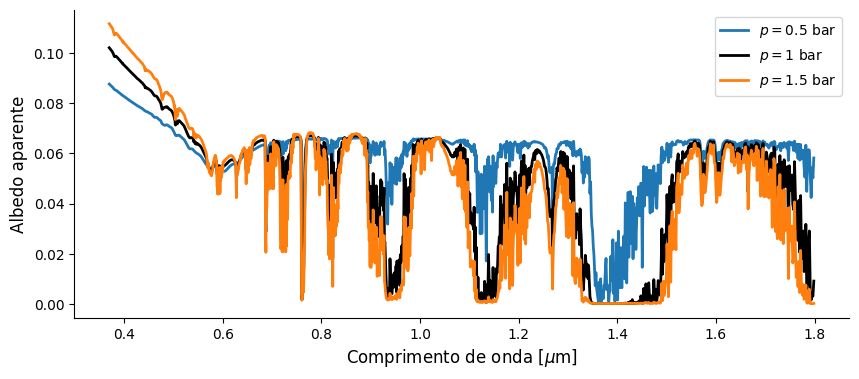

In [17]:
spectrum_metade_atm = EspectroAnalise(resultado_metade_atm)
spectrum_15_atm = EspectroAnalise(resultado_15_atm)

_, ax = plt.subplots()
spectrum_metade_atm.plotar_espectro(ax=ax, label="$p = 0.5$ bar", cor_linha="tab:blue")
spectrum.plotar_espectro(ax=ax, label="$p = 1$ bar", cor_linha="black")
spectrum_15_atm.plotar_espectro(ax=ax, label="$p = 1.5$ bar", cor_linha="tab:orange")
ax.legend();

Quando a pressão atmosférica diminui, é geralmente um indicativo de uma atmosfera mais rarefeita. Em contrapartida, uma pressão atmosférica mais elevada sugere uma atmosfera mais densa e expansiva. A correlação entre a densidade atmosférica e a visibilidade das assinaturas espectrais está intrinsecamente ligada à interação fóton-molécula. Em uma atmosfera densa, as moléculas presentes têm mais oportunidades de interagir com os fótons, resultando em assinaturas espectrais mais pronunciadas. No entanto, quando a atmosfera é mais rarefeita, essas interações diminuem, levando a uma atenuação significativa das assinaturas espectrais.

## Geração de modelos

In [21]:
aleatorio = config.copy()

modificador_aleatorio(aleatorio)
mod_telescopio(aleatorio, instrumento="HWC")
resultado_random = psg.run(aleatorio)
spectrum_random = EspectroAnalise(resultado_random)

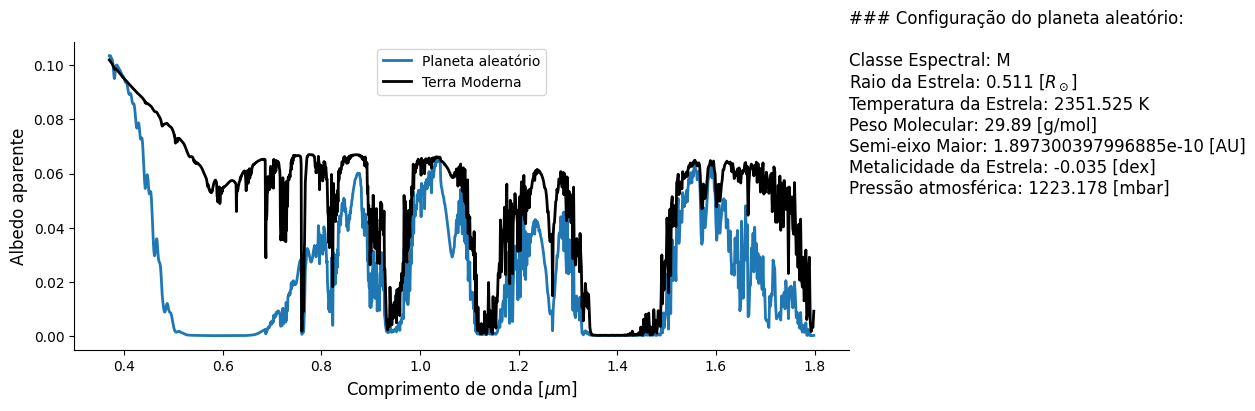

In [22]:
CLASSE_ESPECTRAL = aleatorio['OBJECT-STAR-TYPE']
RAIO_ESTRELA = aleatorio['OBJECT-STAR-RADIUS']
TEMPERATURA_ESTRELA = aleatorio['OBJECT-STAR-TEMPERATURE']
PESO_MOLECULAR = aleatorio['ATMOSPHERE-WEIGHT']
SEMI_EIXO_MAIOR = aleatorio['OBJECT-STAR-DISTANCE']
METALICIDADE_ESTRELA = aleatorio['OBJECT-STAR-METALLICITY']
PRESSAO_ATMO = aleatorio["ATMOSPHERE-PRESSURE"]

_, ax = plt.subplots()

spectrum_random.plotar_espectro(ax=ax, label="Planeta aleatório")
spectrum.plotar_espectro(ax=ax, cor_linha="k", label="Terra Moderna")
plt.legend(loc = "upper center")

texto = ("### Configuração do planeta aleatório:\n\n"
         f"Classe Espectral: {CLASSE_ESPECTRAL}\n"
         f"Raio da Estrela: {RAIO_ESTRELA} [$R_\odot$]\n"
         f"Temperatura da Estrela: {TEMPERATURA_ESTRELA} K\n"
         f"Peso Molecular: {PESO_MOLECULAR} [g/mol]\n"
         f"Semi-eixo Maior: {SEMI_EIXO_MAIOR} [AU]\n"
         f"Metalicidade da Estrela: {METALICIDADE_ESTRELA} [dex]\n"
         f"Pressão atmosférica: {PRESSAO_ATMO} [mbar]")

plt.text(1, 0.8, texto,
         horizontalalignment='left',
         verticalalignment='center',
         transform=plt.gca().transAxes)

plt.show()

## Gerando conjunto de dados

In [3]:
# Exemplo de diretório:
dir = "/home/sarah/Documentos/PSGCode"
datagen(nplanetas=4, dir=dir, nome_arq="datagen", instrumento="HWC")


***** MODO DE GERAÇÃO DE DADOS *****
Testing connection to PSG at https://psg.gsfc.nasa.gov/api.php ...
Connected to PSG with success.
> Gerando exoplaneta 1/4...
> Gerando exoplaneta 2/4...
> Gerando exoplaneta 3/4...
> Gerando exoplaneta 4/4...
> Salvando arquivo...
***** Arquivo salvo com sucesso! *****


In [4]:
dados = '../data/datagen.parquet'
dados = pd.read_parquet(dados)
dados.head()

,OBJECT,OBJECT-NAME,OBJECT-DATE,OBJECT-DIAMETER,OBJECT-GRAVITY,OBJECT-GRAVITY-UNIT,OBJECT-STAR-DISTANCE,OBJECT-STAR-VELOCITY,OBJECT-SOLAR-LONGITUDE,OBJECT-SOLAR-LATITUDE,...,ATMOSPHERE-ATYPE,ATMOSPHERE-AABUN,ATMOSPHERE-AUNIT,ATMOSPHERE-ASIZE,OBJECT-STAR-METALLICITY,Wave/freq [um],Total [I/F apparent albedo],Noise,Stellar,Planet
0,Exoplanet,Exoplanet,2017/12/22 15:09,12742,9.807,g,7.193192e-10,0.0,76.145750,19.823305,...,,,,,0.572,"[0.37, 0.37037, 0.37074037, 0.3711111104, 0.37...","[0.11052241, 0.1104398, 0.11036699, 0.11028081...","[7.17427e-11, 8.6031e-11, 1.17577e-10, 8.94209...","[2.85285e-10, 2.85285e-10, 2.85285e-10, 2.8528...","[0.110522, 0.11044, 0.110367, 0.110281, 0.1101..."
1,Exoplanet,Exoplanet,2017/12/22 15:09,12742,9.807,g,2.053230e-09,0.0,138.343213,-53.682947,...,,,,,0.449,"[0.37, 0.37037, 0.37074037, 0.3711111104, 0.37...","[0.11012146, 0.11028806, 0.11061732, 0.1107227...","[1.05202e-10, 1.05513e-10, 1.05813e-10, 1.0606...","[2.3244e-09, 2.3244e-09, 2.3244e-09, 2.3244e-0...","[0.110121, 0.110288, 0.110617, 0.110723, 0.110..."
2,Exoplanet,Exoplanet,2017/12/22 15:09,12742,9.807,g,3.256463e-09,0.0,240.145087,4.574193,...,,,,,-0.889,"[0.37, 0.37037, 0.37074037, 0.3711111104, 0.37...","[0.042384707, 0.046020798, 0.052584201, 0.0560...","[4.7883e-11, 4.97881e-11, 5.30802e-11, 5.4663e...","[5.84693e-09, 5.84693e-09, 5.84693e-09, 5.8469...","[0.0423847, 0.0460208, 0.0525842, 0.0560609, 0..."
3,Exoplanet,Exoplanet,2017/12/22 15:09,12742,9.807,g,2.091520e-09,0.0,27.676831,-19.279511,...,,,,,0.253,"[0.37, 0.37037, 0.37074037, 0.3711111104, 0.37...","[0.051181596, 0.054774232, 0.060929115, 0.0642...","[4.19695e-11, 4.33125e-11, 4.55483e-11, 4.6630...","[2.4119e-09, 2.4119e-09, 2.4119e-09, 2.4119e-0...","[0.0511816, 0.0547742, 0.0609291, 0.0642314, 0..."


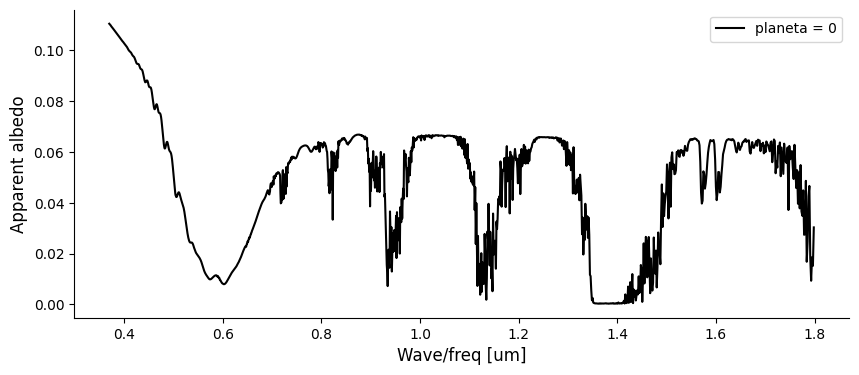

In [36]:
indice = np.random.randint(0, len(dados))
wave_freq = dados.iloc[indice]['Wave/freq [um]']
total_albedo = dados.iloc[indice]['Total [I/F apparent albedo]']

plt.plot(wave_freq, total_albedo, label = f'planeta = {indice}', c = 'k')
plt.xlabel('Wave/freq [um]'); plt.ylabel('Apparent albedo')
plt.legend()
plt.show()

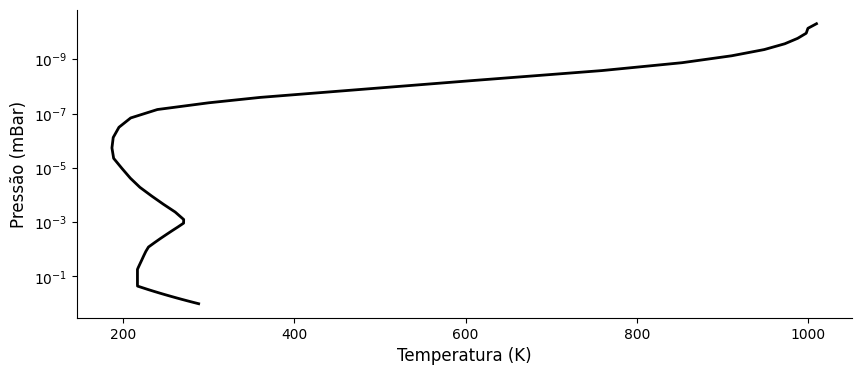

In [37]:
pressoes = []
temperaturas = []

for i in range(60):
    layer_data = dados.iloc[0][f'ATMOSPHERE-LAYER-{i+1}']
    pressao, temperatura = layer_data.split(',')[:2]
    pressoes.append(float(pressao))
    temperaturas.append(float(temperatura))

plt.plot(temperaturas, pressoes, lw = 2, c = 'k')
plt.ylabel('Pressão (mBar)'); plt.xlabel('Temperatura (K)')
plt.gca().invert_yaxis()
plt.yscale('log')
plt.show()

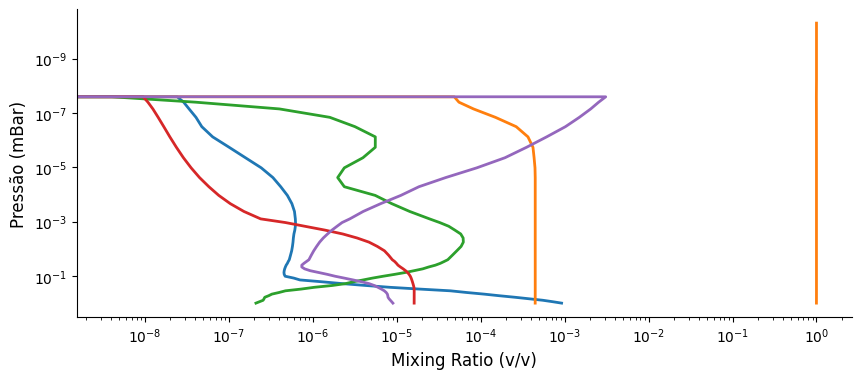

In [38]:
moleculas = dados.iloc[indice]['ATMOSPHERE-LAYERS-MOLECULES'].split(',')
mixing_ratios = [[] for _ in range(len(moleculas))]

for i in range(60):
    layer_data = dados.iloc[0][f'ATMOSPHERE-LAYER-{i+1}']
    mixing_values = layer_data.split(',')[2:]
    for j, value in enumerate(mixing_values):
        mixing_ratios[j].append(float(value))

plt.figure(figsize = (10, 4))

for i, mol in enumerate(moleculas):
    plt.loglog(mixing_ratios[i], pressoes, label=f'{mol}', lw = 2)

plt.ylabel('Pressão (mBar)'); plt.xlabel('Mixing Ratio (v/v)')
plt.gca().invert_yaxis()
plt.show()